In [44]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# ML library
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import pickle


### Loading Data and Data Summary

In [45]:
algorithms = {
    # 'LinearSVC-OVR': LinearSVC(multi_class='ovr', random_state=42, max_iter=5000),
    'SVC-RBF': SVC(kernel='rbf', probability=True,random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    # 'Neural-Network-5': MLPClassifier(hidden_layer_sizes=[5], max_iter=20000, random_state=42),
    # 'DecisionTree': DecisionTreeClassifier(random_state=42),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=42),
    # 'KNeighbors': KNeighborsClassifier(n_neighbors=5),
}
file_path = '../outputs/11-12-2025/features_data_consolidation.csv'
# file_path = 'features_data_testing_1.csv'
np.random.seed(42)

##Program Starting Here!

In [46]:
def apply_sampling(X, y):
  # summarize class distribution
  print("Original :",Counter(y))
  rus = RandomUnderSampler(sampling_strategy={0: len(y[y != 0])}, random_state=42)
  X_rus, y_rus = rus.fit_resample(X, y)
  print("\nAfter Random Undersampling on class 0:", Counter(y_rus))
  return X_rus, y_rus

In [47]:
# Train and test model
def trainAndTestSplitData(X_features, y_features):
  # split into train/test sets with same class ratio
  trainX, testX, trainy, testy = model_selection.train_test_split(X_features, y_features, test_size=0.2,random_state=42, stratify=y_features)
  return trainX, testX, trainy, testy

In [48]:
def execute_model(trainX, testX, trainy, testy, model, create_pickle=True):
  # fit model
  model.fit(trainX, trainy)
  #save model to pickle file
  if create_pickle:
      with open(f'../models/{model.__class__.__name__}_model.pkl', 'wb') as f:
          pickle.dump(model, f)
  
  # predict on test set
  yhat = model.predict(testX)
  # evaluate predictions
  acc = metrics.accuracy_score(testy, yhat)
  prec = metrics.precision_score(testy, yhat, average='weighted')
  recall = metrics.recall_score(testy, yhat, average='weighted')
  f1_score = metrics.f1_score(testy, yhat, average='weighted')
  # Get classification report as dict for class-wise metrics
  classification_report = metrics.classification_report(testy, yhat, output_dict=True)
  return acc, prec, recall, f1_score, classification_report


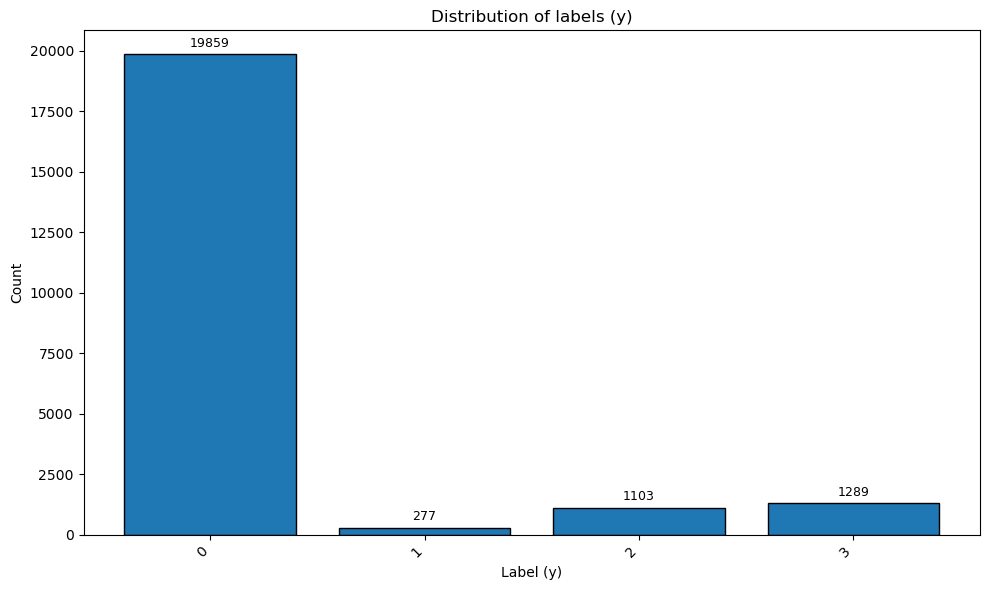

Original : Counter({0: 19859, 3: 1289, 2: 1103, 1: 277})

After Random Undersampling on class 0: Counter({0: 2669, 3: 1289, 2: 1103, 1: 277})
Original number of features: 3178
Number of features after PCA: 757


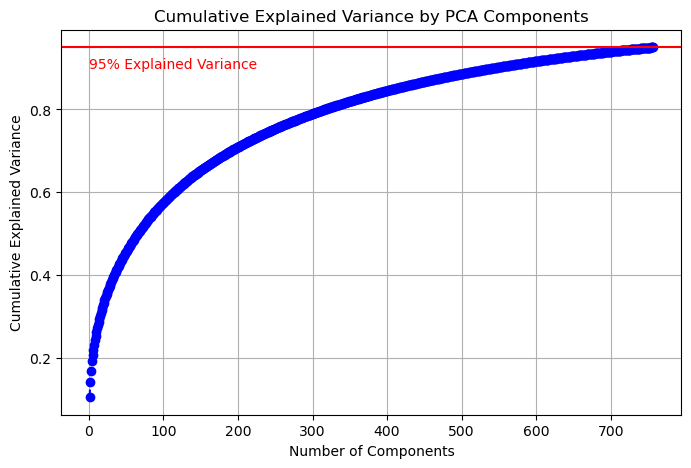

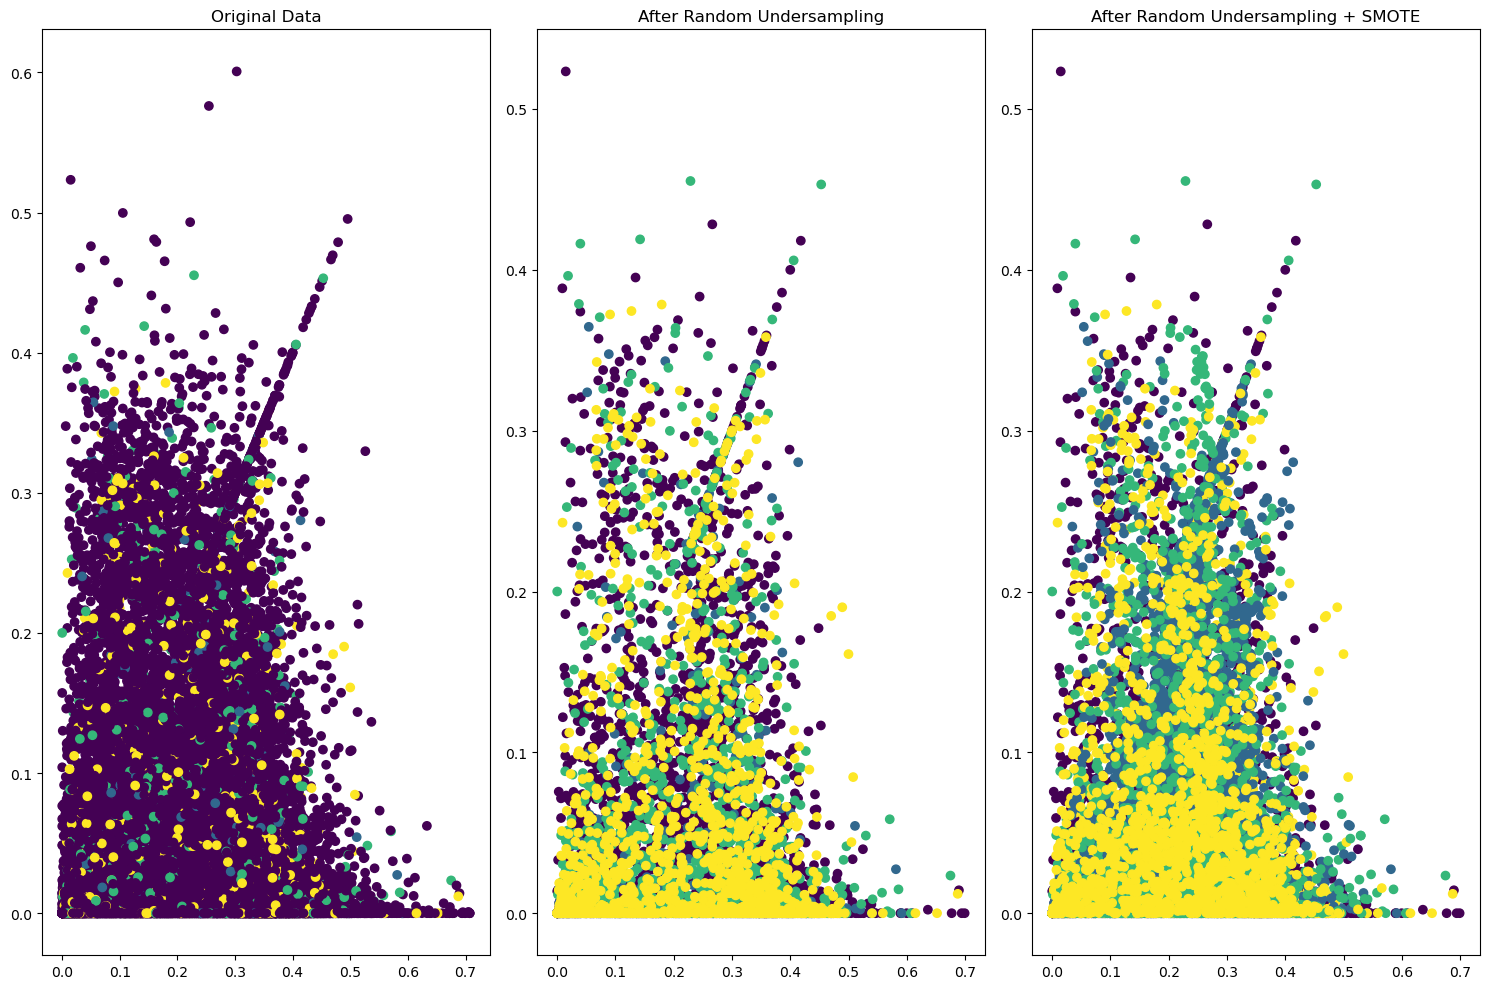

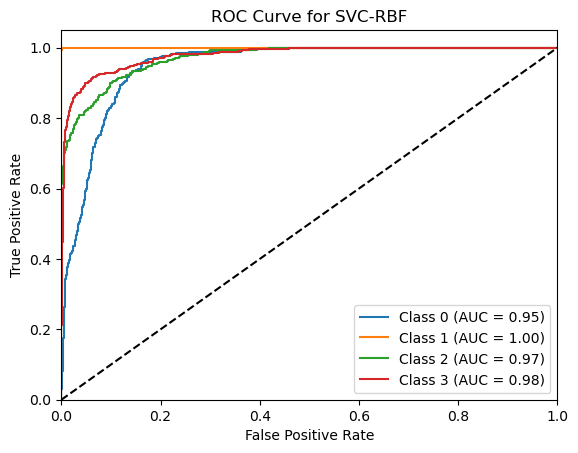

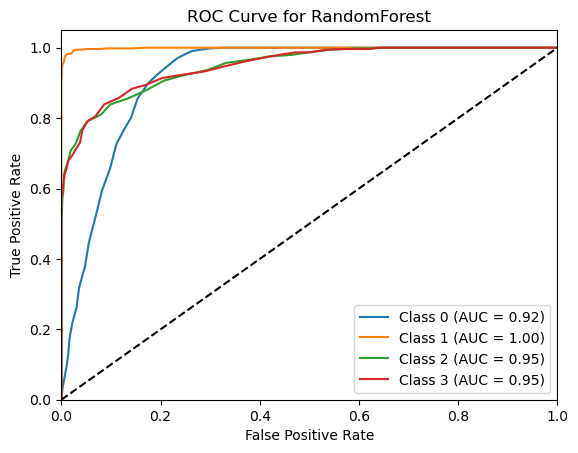

In [49]:
apply_manual_undersampling = True
df = pd.read_csv(file_path)
df_clean = df.dropna()
X = df_clean.drop(['image','tile_number', 'tile_i', 'tile_j', 'y'], axis=1)
y = df_clean['y']

counts = df_clean['y'].value_counts().sort_index()   # or .sort_values(ascending=False)
plt.figure(figsize=(10,6))
bars = plt.bar(counts.index.astype(str), counts.values, color='tab:blue', edgecolor='k')
plt.xlabel('Label (y)')
plt.ylabel('Count')
plt.title('Distribution of labels (y)')
plt.xticks(rotation=45, ha='right')

# annotate counts on top of each bar
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + max(counts.values)*0.01, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# if apply_manual_undersampling:
#     ### Step 1: Apply Random Undersampling on class 0
#     X_us, y_us = apply_sampling(X, y)
#     ### Step 2: Train and Test Split on undersampled data
#     trainX, testX, trainy, testy = trainAndTestSplitData(X_us, y_us)
# else:
#     ### Step 2: Train and Test Split on original data
#     trainX, testX, trainy, testy = trainAndTestSplitData(X, y)
    
#### SMOTE - for multiclass, use 'not majority' or dict
X_us, y_us = apply_sampling(X, y)
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X_us, y_us)

#Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_smote)
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
#Perform PCA
pca = PCA(n_components=0.95)  # retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

#Save pca into picjkle file
with open('../models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

print(f'Original number of features: {X_smote.shape[1]}')
print(f'Number of features after PCA: {X_pca.shape[1]}')

#calculate cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.90, '95% Explained Variance', color = 'red', fontsize=10)
plt.show()
### Plotting - Feature scatter plots
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].scatter(X.iloc[:, 0], X.iloc[:, 2], c = y)
ax[0].set_title("Original Data")
ax[1].scatter(X_us.iloc[:, 0], X_us.iloc[:, 2], c = y_us)
ax[1].set_title("After Random Undersampling")
ax[2].scatter(X_smote.iloc[:, 0], X_smote.iloc[:, 2], c = y_smote)
ax[2].set_title("After Random Undersampling + SMOTE")
plt.tight_layout()
plt.show()

train_pca_X, test_pca_X, train_pca_y, test_pca_y = trainAndTestSplitData(X_pca, y_smote)
 
all_model_reports_list = []
for model_name, model in algorithms.items():
   
    # acc_orig, prec_orig, recall_orig, f1_orig, report_orig = execute_model(trainX, testX, trainy, testy, model, create_pickle=False)
    acc_smote, prec_smote, recall_smote, f1_smote, report_smote = execute_model(train_pca_X, test_pca_X, train_pca_y, test_pca_y, model)
    df_result = pd.DataFrame({
        'Accuracy': [acc_smote ],
        'Precision': [ prec_smote],
        'Recall': [ recall_smote],
        'F1_score': [f1_smote]
    })

    df_result.index = ['RUS + SMOTE']

    # Store classification reports for later use
    # Append the reports for the current model to our list
    all_model_reports_list.append({
        'Model': model_name,
        'RUS + SMOTE': report_smote
    })
    
    from sklearn.metrics import roc_curve, auc

    y_proba = model.predict_proba(test_pca_X)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(test_pca_y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_pca_y == i, y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [50]:

# Now, let's process the collected reports and display them in a table.
records = []
for report_item in all_model_reports_list:
    model_name = report_item['Model']
    for technique, report in report_item.items():
        if technique == 'Model':
            continue
        
        # Extract overall metrics
        records.append({
            'Model': model_name,
            'Technique': technique,
            'Class': 'accuracy',
            'F1-Score': report.get('accuracy', None),
            'Precision': None,
            'Recall': None,
            'Support': report.get('macro avg', {}).get('support', None)
        })
        
        # Extract class-specific and average metrics
        for class_label, metrics in report.items():
            if isinstance(metrics, dict): # This will capture classes and averages like 'macro avg'
                records.append({
                    'Model': model_name,
                    'Technique': technique,
                    'Class': class_label,
                    'F1-Score': metrics.get('f1-score'),
                    'Precision': metrics.get('precision'),
                    'Recall': metrics.get('recall'),
                    'Support': metrics.get('support')
                })

# Create a DataFrame and display it
df_reports = pd.DataFrame(records)

# Pivot for a more readable, wide-format table
report_table = df_reports.pivot_table(
    index=['Model', 'Technique'], 
    columns='Class', 
    values='F1-Score'
)

# Reorder columns for better readability
desired_order = [c for c in sorted(df_reports['Class'].unique(), key=lambda x: (str.isdigit(x), x)) if c in report_table.columns]
report_table = report_table[desired_order]


print("--- All Model Reports (F1-Scores) ---")
# Display the styled DataFrame
report_table.style.background_gradient(cmap='viridis', axis=1).format("{:.4f}").set_caption("F1-Scores by Model, Technique, and Class")

--- All Model Reports (F1-Scores) ---


,Class,accuracy,macro avg,weighted avg,0,1,2,3
Model,Technique,,,,,,,
RandomForest,RUS + SMOTE,0.8310,0.8330,0.8330,0.7317,0.9860,0.7984,0.8161
SVC-RBF,RUS + SMOTE,0.8750,0.8771,0.8771,0.7918,0.9953,0.8321,0.8893


In [ ]:
def apply_nms(predictions_df, iou_threshold=0.5, conf_threshold=0.5):
    """
    Apply Non-Maximum Suppression to filter overlapping tile predictions.
    
    Parameters:
    - predictions_df: DataFrame with columns ['image', 'tile_i', 'tile_j', 'prediction', 'confidence']
    - iou_threshold: IoU threshold for suppression (default 0.5)
    - conf_threshold: Minimum confidence to consider a detection (default 0.5)
    
    Returns:
    - DataFrame with suppressed predictions
    """
    import numpy as np
    
    def calculate_iou(box1, box2):
        """Calculate IoU between two boxes [x1, y1, x2, y2]"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def tile_to_bbox(tile_i, tile_j, img_height=800, img_width=600):
        """Convert tile indices to bounding box coordinates"""
        tile_height = img_height // 8
        tile_width = img_width // 8
        
        x1 = tile_j * tile_width
        y1 = tile_i * tile_height
        x2 = x1 + tile_width
        y2 = y1 + tile_height
        
        return [x1, y1, x2, y2]
    
    results = []
    
    # Process each image separately
    for image_name in predictions_df['image'].unique():
        img_preds = predictions_df[predictions_df['image'] == image_name].copy()
        
        # Process each class separately (bat, ball, stadium)
        for class_label in img_preds['prediction'].unique():
            if class_label == 0:  # Skip background class
                continue
            
            class_preds = img_preds[img_preds['prediction'] == class_label].copy()
            
            # Filter by confidence threshold
            class_preds = class_preds[class_preds['confidence'] >= conf_threshold]
            
            if len(class_preds) == 0:
                continue
            
            # Convert tiles to bboxes
            boxes = []
            confidences = []
            indices = []
            
            for idx, row in class_preds.iterrows():
                bbox = tile_to_bbox(row['tile_i'], row['tile_j'])
                boxes.append(bbox)
                confidences.append(row['confidence'])
                indices.append(idx)
            
            # Sort by confidence (descending) - FIX: Create index mapping
            sorted_indices = np.argsort(confidences)[::-1]
            
            # NMS algorithm
            keep = []
            while len(sorted_indices) > 0:
                # Pick the box with highest confidence
                current_idx = int(sorted_indices[0])  # FIX: Convert to int
                keep.append(current_idx)
                
                if len(sorted_indices) == 1:
                    break
                
                # Calculate IoU with remaining boxes
                current_box = boxes[current_idx]
                remaining_indices = []
                
                for idx in sorted_indices[1:]:
                    idx = int(idx)  # FIX: Convert to int
                    iou = calculate_iou(current_box, boxes[idx])
                    if iou < iou_threshold:
                        remaining_indices.append(idx)
                
                sorted_indices = np.array(remaining_indices)  # FIX: Convert back to array
            
            # Keep only selected predictions - FIX: Direct indexing
            for list_idx in keep:
                results.append(class_preds.iloc[list_idx])
    
    return pd.DataFrame(results) if results else pd.DataFrame()


# Usage example with your model predictions:
def predict_with_nms(test_file_path, model, scaler, pca, iou_threshold=0.3, conf_threshold=0.3):
    """
    Make predictions on test data and apply NMS.
    """
    # Load test data
    df_test = pd.read_csv(test_file_path)
    df_clean = df_test.dropna()
    
    # Keep metadata for later
    metadata = df_clean[['image', 'tile_i', 'tile_j']].copy()
    
    # Prepare features
    X_test = df_clean.drop(['image', 'tile_i', 'tile_j'], axis=1)
    
    # Apply same preprocessing as training
    X_scaled = scaler.transform(X_test)
    X_pca = pca.transform(X_scaled)
    
    # Get predictions and probabilities
    predictions = model.predict(X_pca)
    probabilities = model.predict_proba(X_pca)
    
    # Get confidence (max probability) for each prediction
    confidences = np.max(probabilities, axis=1)
    
    # Create results dataframe
    results_df = metadata.copy()
    results_df['prediction'] = predictions
    results_df['confidence'] = confidences
    
    # Add probabilities for each class
    for i in range(probabilities.shape[1]):
        results_df[f'prob_class_{i}'] = probabilities[:, i]
    
    # Apply NMS
    nms_results = apply_nms(results_df, iou_threshold=iou_threshold, conf_threshold=conf_threshold)
    
    print(f"Before NMS: {len(results_df)} predictions")
    print(f"After NMS: {len(nms_results)} predictions")
    print(f"\nClass distribution after NMS:")
    print(nms_results['prediction'].value_counts())
    
    return results_df, nms_results


# Example usage:
# Load your trained model, scaler, and PCA
with open('../models/RandomForestClassifier_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../models/pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

# Make predictions with NMS
all_preds, final_preds = predict_with_nms(
    'features_data_test_pexels.csv',
    model, 
    scaler, 
    pca,
    iou_threshold=0.3,  # Lower = more aggressive suppression
    conf_threshold=0.3   # Minimum confidence to keep
)

# Visualize results
final_preds.to_csv('../outputs/predictions_with_nms.csv', index=False)

In [ ]:
# file_path = 'features_data_testing_1.csv'
# np.random.seed(42)

# df = pd.read_csv(file_path)
# df_clean = df.dropna()
# X = df_clean.drop(['image', 'tile_i', 'tile_j'], axis=1)
# print(X.shape)

# #Apply MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # #Perform PCA
# # pca = PCA(n_components=484)  # retain 95% of variance
# # X_pca = pca.fit_transform(X_scaled)

# #Load pca from pickle file
# with open('../models/pca_model.pkl', 'rb') as f:
#     pca = pickle.load(f)

# X_pca = pca.transform(X_scaled)

# #load pickle file from ../models/RandomForest_model.pkl and use it for prediction
# with open('../models/RandomForestClassifier_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# prediction = loaded_model.predict(X_pca)
# print(prediction)